In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
from google.colab import files
from PIL import Image
import numpy as np
from numpy import asarray 
import pandas as pd
import torchvision
from torchvision import transforms
import xgboost as xgb
import sklearn
from sklearn.metrics import mean_squared_error

In [ ]:
# upload files from computer

labels_array = []

data = {}

# how many images from each folder to take
num = 50
image_size = 100

In [ ]:
# add empty arrays to dictionary
slots = image_size * image_size * 3
for i in range(slots):
  data[i] = []

In [ ]:
# add target

data['labels'] = labels_array

In [ ]:
def process_image(image):
  """
  Takes in image. Returns padded numpy array. 
  """
  PIL_image = image[0] # get PIL Image only
  PIL_image.thumbnail((image_size, image_size)) # resize PIL image
  np_array = np.array(PIL_image) # convert to numpy array
  result = np.zeros((image_size, image_size, 3))
  result[:np_array.shape[0],:np_array.shape[1]] = np_array
  # result currently holds the padded image
  flat = result.flatten()
  # add values to data dictionary
  for i in range(slots):
    data[i].append(flat[i])


In [ ]:
# none
none_path = '/content/gdrive/My Drive/riskmap_urop/all_none'
all_none = torchvision.datasets.ImageFolder(root = none_path)
# images come in as tuple of (PIL Image, 0)
#for image in all_none:
for i in range(num):
  image = all_none[i]
  result = process_image(image)
  labels_array.append(0)

In [ ]:
# mild
mild_path = '/content/gdrive/My Drive/riskmap_urop/all_mild'
all_mild = torchvision.datasets.ImageFolder(root = mild_path)
#for image in all_mild:
for i in range(num):
  image = all_mild[i]
  result = process_image(image)
  labels_array.append(1)

In [ ]:
# severe
severe_path = '/content/gdrive/My Drive/riskmap_urop/all_severe'
all_severe = torchvision.datasets.ImageFolder(root = severe_path)
#for image in all_severe:
for i in range(num):
  image = all_severe[i]
  result = process_image(image)
  labels_array.append(2)

In [ ]:
df = pd.DataFrame(data)

In [ ]:
# split into data and target
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

XGBClassifier is an implementation of the scikit-learn API for XGBoost classification while xgb.train seems to return a native xgb Booster object. 

In [ ]:
# used https://towardsdatascience.com/boosting-techniques-in-python-predicting-hotel-cancellations-62b7a76ffa6c

In [ ]:
# start prediction
xgb_model = xgb.XGBClassifier(max_depth = 3, eta = 0.3, silent = 1, objective = 'multi:softprob', num_class = 3, learning_rate = 0.001, n_estimators = 20, scale_pos_weight = 3)
# xgb_model = xgb.XGBClassifier(learning_rate=0.001, max_depth = 1, n_estimators = 20, scale_pos_weight=5)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
              learning_rate=0.001, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=3,
              seed=None, silent=1, subsample=1, verbosity=1)

In [ ]:
print("Accuracy on training set: {:.3f}".format(xgb_model.score(X_train, y_train)))
print("Accuracy on validation set: {:.3f}".format(xgb_model.score(X_test, y_test)))

Accuracy on training set: 0.933
Accuracy on validation set: 0.267


In [ ]:
from sklearn.metrics import precision_score
print(precision_score(y_test, best_preds, average='macro'))

0.3552631578947369


In [ ]:
xgb_predict = xgb_model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
cm = confusion_matrix(y_test, xgb_predict)
print(cm)
print(classification_report(y_test, xgb_predict))

[[6 0 0]
 [8 1 7]
 [6 1 1]]
              precision    recall  f1-score   support

           0       0.30      1.00      0.46         6
           1       0.50      0.06      0.11        16
           2       0.12      0.12      0.12         8

    accuracy                           0.27        30
   macro avg       0.31      0.40      0.23        30
weighted avg       0.36      0.27      0.18        30



Text(69.0, 0.5, 'Truth')

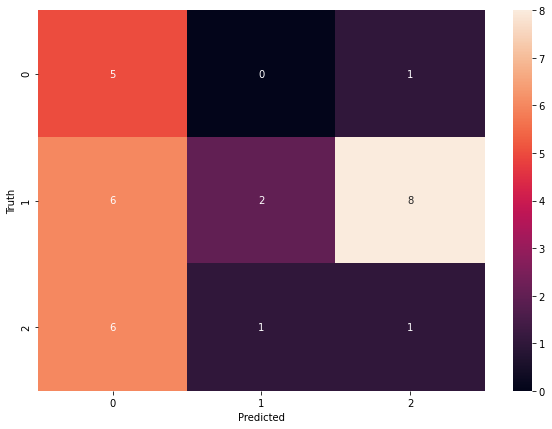

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sn 
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True)
# change label 0 1 2
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
# save model for use later
# from sklearn.externals import joblib
# joblib.dump(bst, 'bst_model.pkl', compress=True)
# bst = joblib.load('bst_model.pkl') # load it later